In [106]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import string
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

# Data Loading

In [107]:
data_path = '../data/disaster_tweets.csv' 
df = pd.read_csv(data_path)

In [108]:
porcentaje = df.target.sum() / len(df)
print(f"Percentage of real disasters: {porcentaje:.2%}")

Percentage of real disasters: 42.97%


# Data Pre-processing

In [109]:
nltk.download("stopwords")
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

def preprocess_string(input_string):
    input_string = input_string.lower() # lowercase strings: this is necessary to don't consider the same word as a different one if it has one letter in upper case.
    split_string = input_string.split(" ") # word by word
    no_url_words = [word for word in split_string if "://" not in word] # pick words that are not links: this is necessary because the URLs don't add meaning to the text, they are only a link to another page and don't give information by itselfs.
    no_url_string = " ".join(no_url_words) # rejoin all words into string
    no_punctuation_string = no_url_string.translate(str.maketrans("", "", string.punctuation)) # remove all punctuation: this is necesary because the puntuaction don't add extra information 
    split_string = no_punctuation_string.split(" ") # list word by word
    no_stopwords_strings = [word for word in split_string if word not in stopwords.words('english')] # remove stopwords: this is necesary because the puntuaction don't add extra information 
    stemmed_words = [lemmatizer.lemmatize(word) for word in no_stopwords_strings] # lemmatize: this is useful because extracting the lema we can obtain the principal meaning of the word (getting words that had suffer contextual modifications as only one)
    output_string = " ".join(stemmed_words) # rejoin string
    while "  " in output_string:
        output_string = output_string.replace("  ", " ") # get rid of double spaces
    return output_string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marcelo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marcelo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [110]:
df_preprocessed = df.copy()
df_preprocessed['text'] = df.text.apply(lambda x: preprocess_string(x))

# Data Splitting and Vectorizing

In [111]:
X_train_pre_vec, X_test_pre_vec, y_train, y_test = train_test_split(df_preprocessed['text'], df_preprocessed['target'], test_size=0.3, random_state=42)

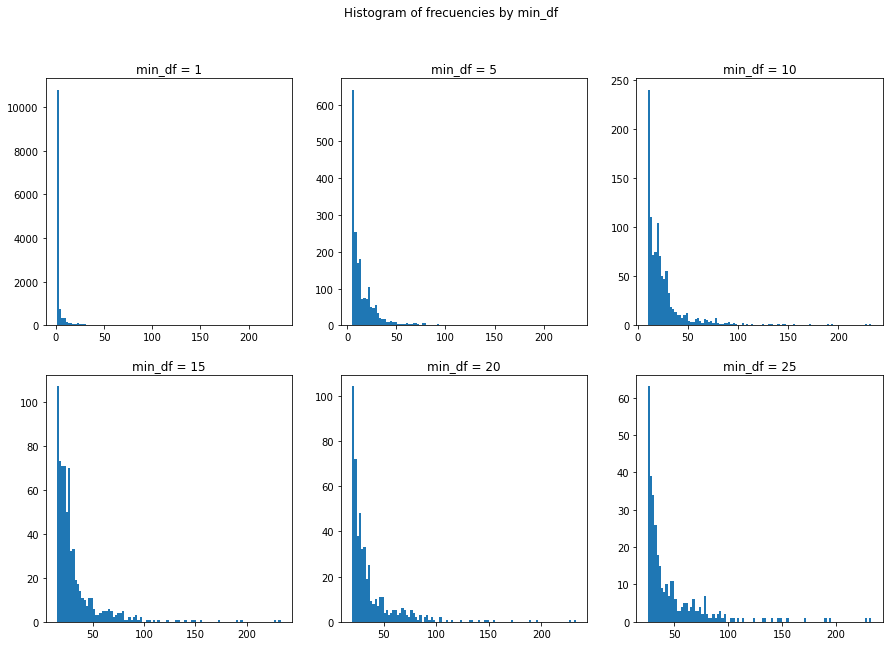

In [112]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Histogram of frecuencies by min_df")
axes = axes.flatten()

dict_X_train = {}
dict_X_test = {}
dict_labels = {}

lst_min_df = [1, 5, 10, 15, 20, 25]

for idx, i in enumerate(lst_min_df):
    vectorizer = CountVectorizer(binary=True, min_df=i)
    X_train = vectorizer.fit_transform(X_train_pre_vec)
    X_test = vectorizer.transform(X_test_pre_vec)
    dict_X_train[i] = X_train
    dict_X_test[i] = X_test
    feature_names = vectorizer.get_feature_names_out()
    dict_labels[i] = feature_names
    axes[idx].hist(X_train.toarray().sum(0), bins = 100)
    axes[idx].set_title(f'min_df = {i}')

plt.show()

In [113]:
for i in lst_min_df:
    print(f'Words in dictionary with min_df = {i}: {dict_X_train[i].shape[1]: ,}')

Words in dictionary with min_df = 1:  13,155
Words in dictionary with min_df = 5:  1,940
Words in dictionary with min_df = 10:  1,046
Words in dictionary with min_df = 15:  696
Words in dictionary with min_df = 20:  516
Words in dictionary with min_df = 25:  340


# Logistic Regression

In [114]:
dict_clf = {}
dict_pred = {}
dict_pred_test = {}
dict_f1 = {}
dict_f1_test = {}

for i in lst_min_df:
    print(f'With min_df = {i}:')
    clf = LogisticRegression(penalty=None, max_iter=500, fit_intercept=False, random_state=42)
    clf.fit(dict_X_train[i].toarray(), y_train)
    dict_clf[i] = clf
    pred = clf.predict(dict_X_train[i])
    dict_pred[i] = pred
    pred_test = clf.predict(dict_X_test[i])
    dict_pred_test[i] = pred_test
    f1 = f1_score(y_train, pred, average='binary')
    dict_f1[i] = f1
    f1_test = f1_score(y_test, pred_test, average='binary')
    dict_f1_test[i] = f1_test
    print(f'F1: {f1}')
    print(f'F1 in test: {f1_test}\n')

With min_df = 1:
F1: 0.9869167030091583
F1 in test: 0.6967675731144176

With min_df = 5:
F1: 0.9550610820244329
F1 in test: 0.6676646706586826

With min_df = 10:
F1: 0.8415276558384548
F1 in test: 0.7155216284987277

With min_df = 15:
F1: 0.796557811120918
F1 in test: 0.7218200620475698

With min_df = 20:
F1: 0.7815888470900642
F1 in test: 0.7007832898172324

With min_df = 25:
F1: 0.7338454586534117
F1 in test: 0.676773145641581



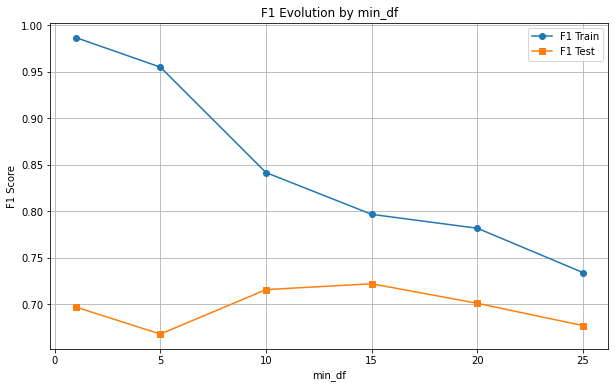

In [115]:
y1 = [dict_f1[x] for x in lst_min_df]
y2 = [dict_f1_test[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()


Significant overfitting is observed in the case of min_df = 1 up to around min_df = 10. After this point, overfitting continues, but it decreases to the point that for min_df = 25, the difference between the training and evaluation F1 scores is only 5.7.

In [123]:
dict_clf_l1 = {}
dict_pred_l1 = {}
dict_pred_test_l1 = {}
dict_f1_l1 = {}
dict_f1_test_l1 = {}
dict_f1_coeffs = {}

lst_alpha = np.linspace(0.1, 4, num=20)#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
C = [1/alpha for alpha in lst_alpha]

for i in lst_min_df:
    dict_clf_c = {}
    dict_pred_c = {}
    dict_pred_test_c = {}
    dict_f1_c = {}
    dict_f1_test_c = {}
    dict_f1_coeffs_c = {}
    print(f'With min_df = {i}:')
    for c in C:
        #print(f'With alpha = {1/c}')
        clf = LogisticRegression(penalty='l1', C=c, max_iter=500, fit_intercept=False, solver='liblinear', random_state=42)
        clf.fit(dict_X_train[i].toarray(), y_train)
        dict_clf_c[c] = clf
        coeffs = clf.coef_[0]
        dict_f1_coeffs_c[c] = coeffs
        pred = clf.predict(dict_X_train[i])
        dict_pred_c[c] = pred
        pred_test = clf.predict(dict_X_test[i])
        dict_pred_test_c[c] = pred_test
        f1 = f1_score(y_train, pred, average='binary')
        dict_f1_c[c] = f1
        f1_test = f1_score(y_test, pred_test, average='binary')
        dict_f1_test_c[c] = f1_test
        #print(f'F1: {f1}')
        #print(f'F1 in test: {f1_test}\n')        
    best_c = max(dict_f1_test_c, key=dict_f1_test_c.get)
    #best_f1_test = dict_f1_test_c[best_c]
    print(f'Best alpha: {1/best_c}')
    dict_clf_l1[i] = dict_clf_c[best_c]
    dict_pred_l1[i] = dict_pred_c[best_c]
    dict_pred_test_l1[i] = dict_pred_test_c[best_c]
    dict_f1_l1[i] = dict_f1_c[best_c]
    dict_f1_test_l1[i] = dict_f1_test_c[best_c]
    dict_f1_coeffs[i] = dict_f1_coeffs_c[best_c]
    print(f'F1: {dict_f1_l1[i]}')
    print(f'F1 in test: {dict_f1_test_l1[i]}\n')

With min_df = 1:
Best alpha: 1.1263157894736844
F1: 0.8407298941202974
F1 in test: 0.7465681098204857

With min_df = 5:
Best alpha: 1.1263157894736844
F1: 0.8335588633288228
F1 in test: 0.7470899470899471

With min_df = 10:
Best alpha: 1.536842105263158
F1: 0.800543970988214
F1 in test: 0.7326519634211942

With min_df = 15:
Best alpha: 1.1263157894736844
F1: 0.7903841833295888
F1 in test: 0.7296726504751848

With min_df = 20:
Best alpha: 1.536842105263158
F1: 0.777014652014652
F1 in test: 0.7206434316353887

With min_df = 25:
Best alpha: 2.5631578947368423
F1: 0.7318926620755165
F1 in test: 0.6875



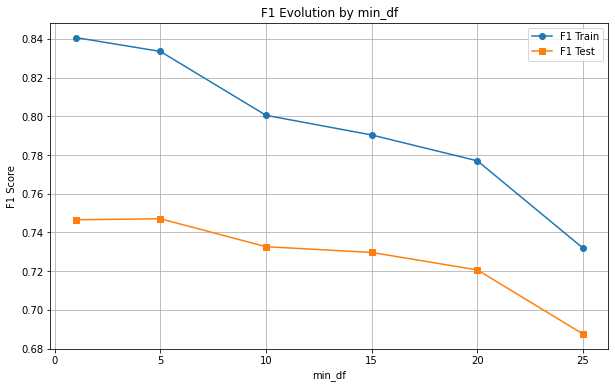

In [117]:
y1 = [dict_f1_l1[x] for x in lst_min_df]
y2 = [dict_f1_test_l1[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()

In [118]:
dict_clf_l2 = {}
dict_pred_l2 = {}
dict_pred_test_l2 = {}
dict_f1_l2 = {}
dict_f1_test_l2 = {}

lst_alpha = np.linspace(0.1, 4, num=20)#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
C = [1/alpha for alpha in lst_alpha]

for i in lst_min_df:
    dict_clf_c = {}
    dict_pred_c = {}
    dict_pred_test_c = {}
    dict_f1_c = {}
    dict_f1_test_c = {}
    print(f'With min_df = {i}:')
    for c in C:
        #print(f'With alpha = {1/c}')
        clf = LogisticRegression(penalty='l2', C=c, max_iter=500, fit_intercept=False, solver='liblinear', random_state=42)
        clf.fit(dict_X_train[i].toarray(), y_train)
        dict_clf_c[c] = clf
        pred = clf.predict(dict_X_train[i])
        dict_pred_c[c] = pred
        pred_test = clf.predict(dict_X_test[i])
        dict_pred_test_c[c] = pred_test
        f1 = f1_score(y_train, pred, average='binary')
        dict_f1_c[c] = f1
        f1_test = f1_score(y_test, pred_test, average='binary')
        dict_f1_test_c[c] = f1_test
        #print(f'F1: {f1}')
        #print(f'F1 in test: {f1_test}\n')        
    best_c = max(dict_f1_test_c, key=dict_f1_test_c.get)
    #best_f1_test = dict_f1_test_c[best_c]
    print(f'Best alpha: {1/best_c}')
    dict_clf_l2[i] = dict_clf_c[best_c]
    dict_pred_l2[i] = dict_pred_c[best_c]
    dict_pred_test_l2[i] = dict_pred_test_c[best_c]
    dict_f1_l2[i] = dict_f1_c[best_c]
    dict_f1_test_l2[i] = dict_f1_test_c[best_c]
    print(f'F1: {dict_f1_l2[i]}')
    print(f'F1 in test: {dict_f1_test_l2[i]}\n')

With min_df = 1:
Best alpha: 1.1263157894736844
F1: 0.9515631880228974
F1 in test: 0.752092050209205

With min_df = 5:
Best alpha: 2.3578947368421055
F1: 0.8407217643127646
F1 in test: 0.7480438184663537

With min_df = 10:
Best alpha: 1.9473684210526316
F1: 0.8071269487750556
F1 in test: 0.7348643006263048

With min_df = 15:
Best alpha: 3.794736842105263
F1: 0.7823765020026703
F1 in test: 0.7341373885684321

With min_df = 20:
Best alpha: 2.768421052631579
F1: 0.774782802405881
F1 in test: 0.7229166666666667

With min_df = 25:
Best alpha: 2.3578947368421055
F1: 0.7329417080885675
F1 in test: 0.6850351161534306



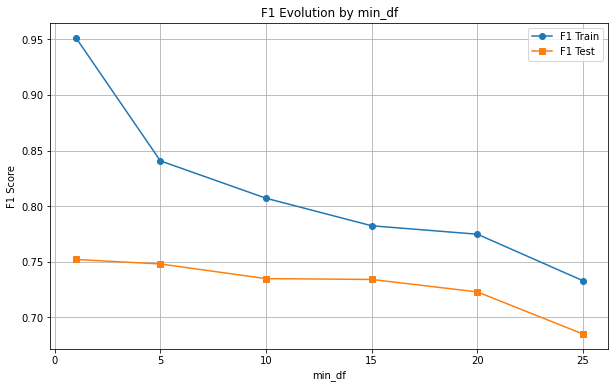

In [119]:
y1 = [dict_f1_l2[x] for x in lst_min_df]
y2 = [dict_f1_test_l2[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()

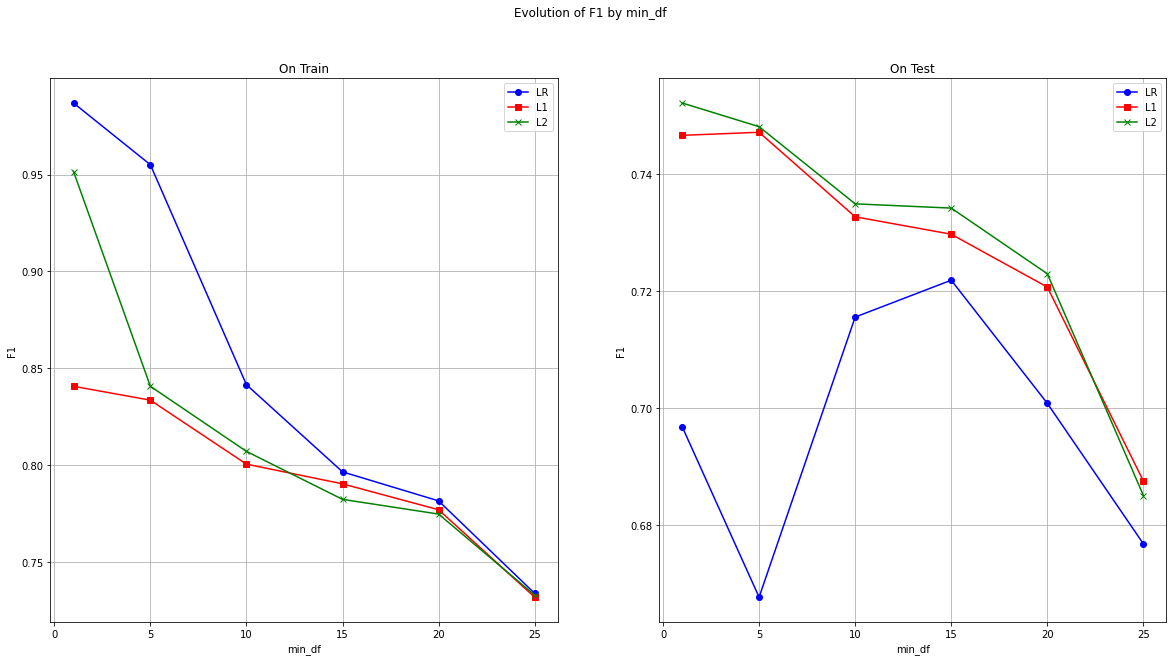

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Evolution of F1 by min_df")
axes = axes.flatten()

f1 = [dict_f1[x] for x in lst_min_df]
f1_l1 = [dict_f1_l1[x] for x in lst_min_df]
f1_l2 = [dict_f1_l2[x] for x in lst_min_df]

f1_test = [dict_f1_test[x] for x in lst_min_df]
f1_test_l1 = [dict_f1_test_l1[x] for x in lst_min_df]
f1_test_l2 = [dict_f1_test_l2[x] for x in lst_min_df]


axes[0].plot(lst_min_df, f1, label='LR', marker='o', color='blue')
axes[0].plot(lst_min_df, f1_l1, label='L1', marker='s', color='red')
axes[0].plot(lst_min_df, f1_l2, label='L2', marker='x', color='green')
axes[0].set_xlabel('min_df')
axes[0].set_ylabel('F1')
axes[0].set_title('On Train')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(lst_min_df, f1_test, label='LR', marker='o', color='blue')
axes[1].plot(lst_min_df, f1_test_l1, label='L1', marker='s', color='red')
axes[1].plot(lst_min_df, f1_test_l2, label='L2', marker='x', color='green')
axes[1].set_xlabel('min_df')
axes[1].set_ylabel('F1')
axes[1].set_title('On Test')
axes[1].legend()
axes[1].grid(True)

plt.show()

As can be seen, regularization by both L1 and L2 is particularly effective for low values of min_df. This effectiveness can be seen in a reduction in overfitting and a better F1 in the test data. Although regularization by L1 and L2 continues to have positive effects for higher values of min_df, these effects are not as significant. This may be because the min_df hyperparameter allows regularization by eliminating rarely used variables (words), so this hyperparameter is already doing what L1 and L2 do.

In [138]:
for i in lst_min_df:
    importance = sorted(zip(feature_names, dict_f1_coeffs[i]), key=lambda x: abs(x[1]), reverse=True)
    print(f'Top 5 of importance with min_df = {i}: {importance[:5]}\n')

Top 5 of importance with min_df = 1: [('bag', -1.0628678374082914), ('there', 0.7166275932693347), ('see', 0.42760586206204637), ('obama', 0.3535073712789345), ('cross', -0.2465572460868698)]

Top 5 of importance with min_df = 5: [('engulfed', 2.73496636820463), ('old', -2.261939301926798), ('lol', -2.0662475680294614), ('island', 1.9538386585650078), ('top', -1.7935239822276647)]

Top 5 of importance with min_df = 10: [('bombed', 2.5616482973772188), ('said', 2.2341986914099863), ('traumatised', 2.0299661265865048), ('show', 1.9793660892983855), ('fall', -1.8714469181889424)]

Top 5 of importance with min_df = 15: [('tragedy', 3.0535037748397755), ('back', 2.934257007812899), ('keep', 2.7066805251815604), ('legionnaire', 2.4498967649975687), ('could', -2.3632780374572193)]

Top 5 of importance with min_df = 20: [('top', 2.932615315113958), ('please', 2.8748468626563044), ('apocalypse', 2.7235489780289024), ('fuck', 2.265059196326618), ('go', 2.1482479686220906)]

Top 5 of importance w

# Bernoulli Naive Bayes

In [140]:
def nb_predictions(x, psis, phis):
    """This returns class assignments and scores under the NB model.

    We compute \\arg\\max_y p(y|x) as \\arg\\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x.toarray(), (1, n, d))
    psis = np.reshape(psis, (K, 1, d))

    psis = psis.clip(1e-14, 1-1e-14) # clip probabilities to avoid log(0)

    # compute log-probabilities
    logpy = np.log(phis).reshape([K,1])
    logpxy = x * np.log(psis) + (1-x) * np.log(1-psis)
    logpyx = logpxy.sum(axis=2) + logpy

    return logpyx.argmax(axis=0).flatten(), logpyx.reshape([K,n])

In [ ]:
dict_pred = {}
dict_pred_test = {}
dict_f1 = {}
dict_f1_test = {}

for i in lst_min_df:
    print(f'With min_df = {i}:')
    n = dict_X_train[i].shape[0] 
    d = dict_X_train[i].shape[1] 
    K = 2 

    psis = np.zeros([K,d])
    phis = np.zeros([K])

    for k in range(K):
        X_k = dict_X_train[i][y_train == k]
        psis[k] = (np.sum(X_k, axis=0) + 1)/ (X_k.shape[0] + 2)
        phis[k] = X_k.shape[0] / float(n)

    pred, logpyx = nb_predictions(dict_X_train[i], psis, phis)
    dict_pred[i] = pred
    pred_test, logpyx = nb_predictions(dict_X_test[i], psis, phis)
    dict_pred_test[i] = pred_test
    f1 = f1_score(y_train, pred, average='binary')
    dict_f1[i] = f1
    f1_test = f1_score(y_test, pred_test, average='binary')
    dict_f1_test[i] = f1_test
    print(f'F1: {f1}')
    print(f'F1 in test: {f1_test}\n')

With min_df = 1:
F1: 0.8880074661689221
F1 in test: 0.74

With min_df = 5:
F1: 0.7973295183595612
F1 in test: 0.7385844748858448

With min_df = 10:
F1: 0.7658959537572254
F1 in test: 0.7291546866014951

With min_df = 15:
F1: 0.7518580676096859
F1 in test: 0.7119033927544566

With min_df = 20:
F1: 0.7457546041616838
F1 in test: 0.7035347776510832

With min_df = 25:
F1: 0.7058250060931026
F1 in test: 0.663164039696439



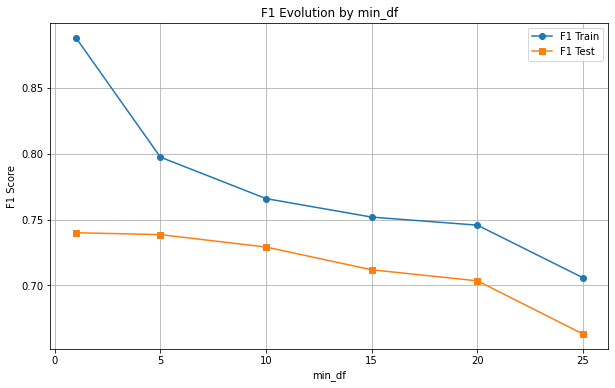

In [150]:
y1 = [dict_f1[x] for x in lst_min_df]
y2 = [dict_f1_test[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()

A result similar to that obtained using L1 or L2 is achieved with considerably less computation time.

# N-gram model

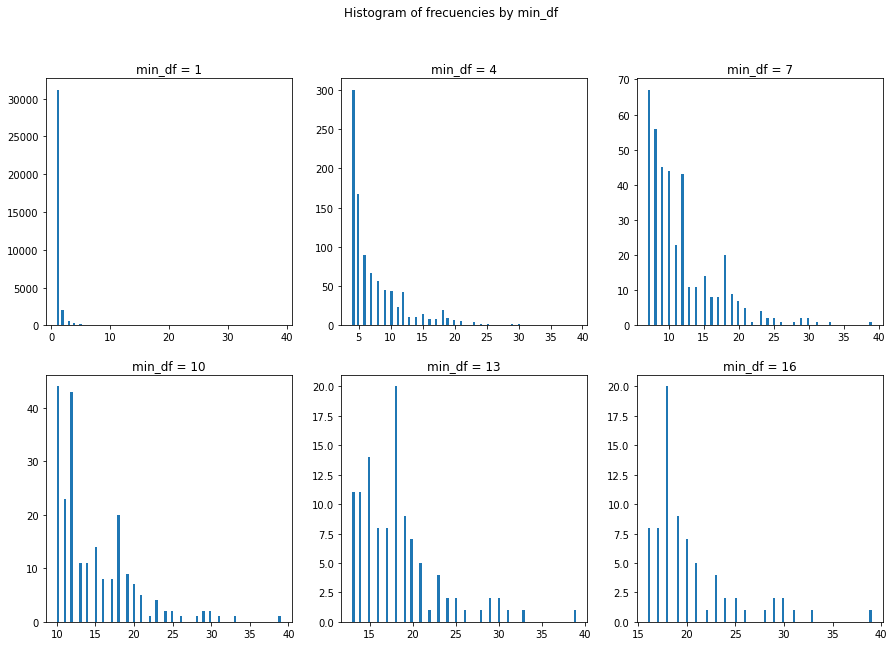

In [152]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Histogram of frecuencies by min_df")
axes = axes.flatten()

dict_X_train = {}
dict_X_test = {}
dict_labels = {}

lst_min_df = [1, 4, 7, 10, 13, 16]

for idx, i in enumerate(lst_min_df):
    vectorizer = CountVectorizer(binary=True, min_df=i, ngram_range=(2,2))
    X_train = vectorizer.fit_transform(X_train_pre_vec)
    X_test = vectorizer.transform(X_test_pre_vec)
    dict_X_train[i] = X_train
    dict_X_test[i] = X_test
    feature_names = vectorizer.get_feature_names_out()
    dict_labels[i] = feature_names
    axes[idx].hist(X_train.toarray().sum(0), bins = 100)
    axes[idx].set_title(f'min_df = {i}')

plt.show()

In [157]:
for i in lst_min_df:
    print(f'Words in dictionary with min_df = {i}: {dict_X_train[i].shape[1]: ,}')

Words in dictionary with min_df = 1:  34,645
Words in dictionary with min_df = 4:  946
Words in dictionary with min_df = 7:  389
Words in dictionary with min_df = 10:  221
Words in dictionary with min_df = 13:  111
Words in dictionary with min_df = 16:  75


In [169]:
two_grams = [x for x in vectorizer.vocabulary_.keys()]

In [170]:
print(f'10 2-grams:\n{two_grams[:10]}')

10 2-grams:
['debris found', 'cross body', 'full read', 'suicide bombing', 'burning building', 'forest fire', 'watch airport', 'airport get', 'get swallowed', 'swallowed sandstorm']


## LR L2

In [153]:
dict_clf_l2 = {}
dict_pred_l2 = {}
dict_pred_test_l2 = {}
dict_f1_l2 = {}
dict_f1_test_l2 = {}

lst_alpha = np.linspace(0.1, 4, num=20)#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
C = [1/alpha for alpha in lst_alpha]

for i in lst_min_df:
    dict_clf_c = {}
    dict_pred_c = {}
    dict_pred_test_c = {}
    dict_f1_c = {}
    dict_f1_test_c = {}
    print(f'With min_df = {i}:')
    for c in C:
        #print(f'With alpha = {1/c}')
        clf = LogisticRegression(penalty='l2', C=c, max_iter=500, fit_intercept=False, solver='liblinear', random_state=42)
        clf.fit(dict_X_train[i].toarray(), y_train)
        dict_clf_c[c] = clf
        pred = clf.predict(dict_X_train[i])
        dict_pred_c[c] = pred
        pred_test = clf.predict(dict_X_test[i])
        dict_pred_test_c[c] = pred_test
        f1 = f1_score(y_train, pred, average='binary')
        dict_f1_c[c] = f1
        f1_test = f1_score(y_test, pred_test, average='binary')
        dict_f1_test_c[c] = f1_test
        #print(f'F1: {f1}')
        #print(f'F1 in test: {f1_test}\n')        
    best_c = max(dict_f1_test_c, key=dict_f1_test_c.get)
    #best_f1_test = dict_f1_test_c[best_c]
    print(f'Best alpha: {1/best_c}')
    dict_clf_l2[i] = dict_clf_c[best_c]
    dict_pred_l2[i] = dict_pred_c[best_c]
    dict_pred_test_l2[i] = dict_pred_test_c[best_c]
    dict_f1_l2[i] = dict_f1_c[best_c]
    dict_f1_test_l2[i] = dict_f1_test_c[best_c]
    print(f'F1: {dict_f1_l2[i]}')
    print(f'F1 in test: {dict_f1_test_l2[i]}\n')

With min_df = 1:
Best alpha: 1.7421052631578948
F1: 0.9820568927789934
F1 in test: 0.6674570243034973

With min_df = 4:
Best alpha: 1.1263157894736844
F1: 0.6013824884792627
F1 in test: 0.5061107117181883

With min_df = 7:
Best alpha: 0.5105263157894737
F1: 0.5146740809391411
F1 in test: 0.45933734939759036

With min_df = 10:
Best alpha: 2.973684210526316
F1: 0.44466082440765986
F1 in test: 0.38893280632411065

With min_df = 13:
Best alpha: 0.1
F1: 0.3737166324435318
F1 in test: 0.33112582781456956

With min_df = 16:
Best alpha: 0.1
F1: 0.3307365439093484
F1 in test: 0.2910958904109589



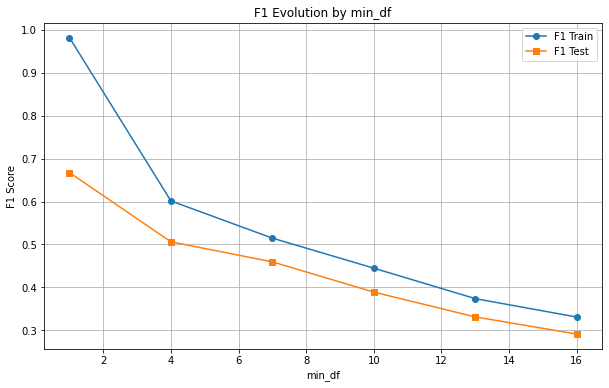

In [154]:
y1 = [dict_f1_l2[x] for x in lst_min_df]
y2 = [dict_f1_test_l2[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()

## Bernoulli Naive Bayes

In [155]:
dict_pred = {}
dict_pred_test = {}
dict_f1 = {}
dict_f1_test = {}

for i in lst_min_df:
    print(f'With min_df = {i}:')
    n = dict_X_train[i].shape[0] 
    d = dict_X_train[i].shape[1] 
    K = 2 

    psis = np.zeros([K,d])
    phis = np.zeros([K])

    for k in range(K):
        X_k = dict_X_train[i][y_train == k]
        psis[k] = (np.sum(X_k, axis=0) + 1)/ (X_k.shape[0] + 2)
        phis[k] = X_k.shape[0] / float(n)

    pred, logpyx = nb_predictions(dict_X_train[i], psis, phis)
    dict_pred[i] = pred
    pred_test, logpyx = nb_predictions(dict_X_test[i], psis, phis)
    dict_pred_test[i] = pred_test
    f1 = f1_score(y_train, pred, average='binary')
    dict_f1[i] = f1
    f1_test = f1_score(y_test, pred_test, average='binary')
    dict_f1_test[i] = f1_test
    print(f'F1: {f1}')
    print(f'F1 in test: {f1_test}\n')

With min_df = 1:
F1: 0.9280259199259431
F1 in test: 0.45161290322580644

With min_df = 4:
F1: 0.5378622623870365
F1 in test: 0.45247446975648076

With min_df = 7:
F1: 0.46204403549129147
F1 in test: 0.40129975629569453

With min_df = 10:
F1: 0.41122759553601623
F1 in test: 0.3458646616541353

With min_df = 13:
F1: 0.3552908199018921
F1 in test: 0.3030821917808219

With min_df = 16:
F1: 0.3165104542177361
F1 in test: 0.27017543859649124



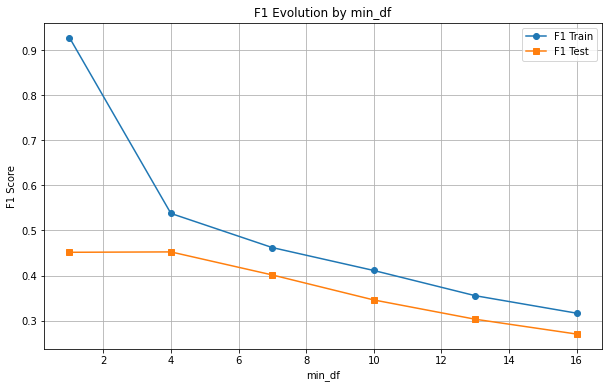

In [156]:
y1 = [dict_f1[x] for x in lst_min_df]
y2 = [dict_f1_test[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()

It can be seen that in both the regularized LR and NB cases, performance is significantly lower when the vectorization criterion is changed. This is possibly due to the inability of these models to interpret the semantics of word sequences, meaning that variables that should be interpreted as very similar may be interpreted by the model as completely different variables.